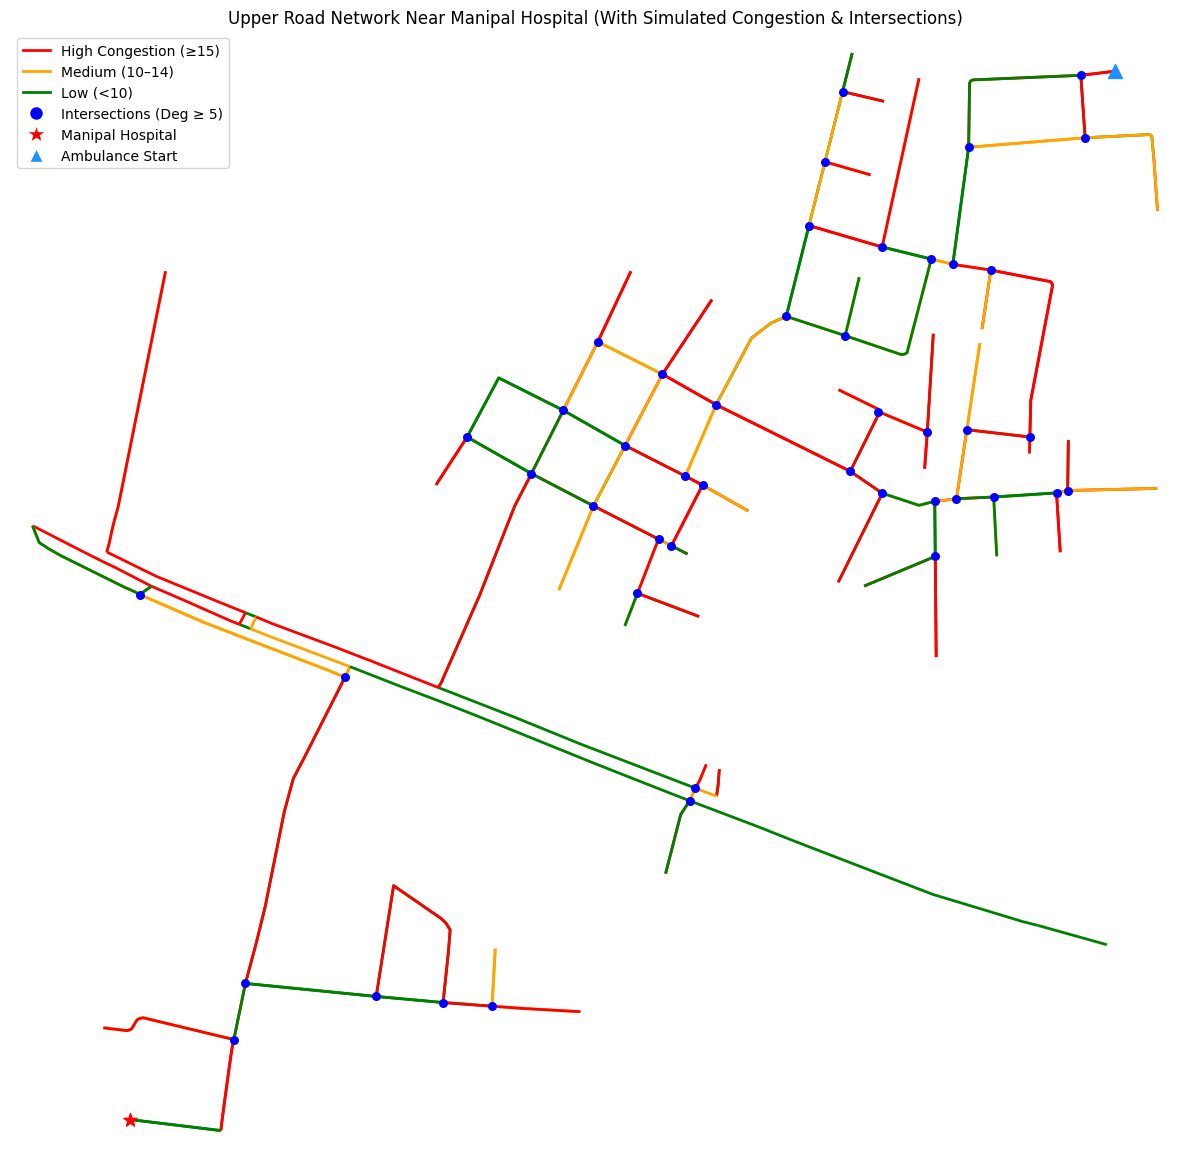

In [4]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import random
!pip install osmnx haversine qiskit qiskit-optimization --quiet

# Step 1: Define settings and coordinates
ox.settings.use_cache = True
ox.settings.log_console = True

# Coordinates near Manipal Hospital Sarjapur Road (upper section)
lat, lon = 12.9116, 77.6866
point = (lat, lon)

# Step 2: Get the graph within 500m radius (focusing on upper region)
G = ox.graph_from_point(point, dist=500, dist_type='bbox', network_type='drive')

# Step 3: Simplify and project graph
#G = ox.simplify_graph(G)
G_proj = ox.project_graph(G)

# Step 4: Simulate congestion by assigning random weights to edges
for u, v, k, data in G_proj.edges(keys=True, data=True):
    weight = random.randint(5, 20)
    data['weight'] = weight

# Step 5: Define color for congestion levels
def get_edge_color(weight):
    if weight >= 15:
        return 'red'      # High congestion
    elif weight >= 10:
        return 'orange'   # Medium congestion
    else:
        return 'green'    # Low congestion

edge_colors = [get_edge_color(data['weight']) for u, v, k, data in G_proj.edges(keys=True, data=True)]

# Step 6: Identify intersections with high degree
degree_threshold = 5
intersection_nodes = [node for node, degree in dict(G_proj.degree()).items() if degree >= degree_threshold]

# Step 7: Plot everything
fig, ax = plt.subplots(figsize=(12, 12))
ox.plot_graph(
    G_proj,
    ax=ax,
    node_size=0,
    edge_color=edge_colors,
    edge_linewidth=2,
    show=False,
    close=False,
    bgcolor='white'
)

# Step 8: Plot intersection nodes (highlighted in blue)
x_nodes = [G_proj.nodes[n]['x'] for n in intersection_nodes]
y_nodes = [G_proj.nodes[n]['y'] for n in intersection_nodes]
ax.scatter(x_nodes, y_nodes, c='blue', s=30, label='Intersections (Deg ≥ 5)', zorder=3)

# Step 9: Plot hospital location
ax.scatter(
    G_proj.nodes[ox.nearest_nodes(G_proj, lon, lat)]['x'],
    G_proj.nodes[ox.nearest_nodes(G_proj, lon, lat)]['y'],
    c='red', s=100, marker='*', label='Manipal Hospital', zorder=4
)

# Step 10: Legend and title
legend_elements = [
    plt.Line2D([0], [0], color='red', lw=2, label='High Congestion (≥15)'),
    plt.Line2D([0], [0], color='orange', lw=2, label='Medium (10–14)'),
    plt.Line2D([0], [0], color='green', lw=2, label='Low (<10)'),
    plt.Line2D([0], [0], marker='o', color='w', label='Intersections (Deg ≥ 5)',
               markerfacecolor='blue', markersize=10),
    plt.Line2D([0], [0], marker='*', color='w', label='Manipal Hospital',
               markerfacecolor='red', markersize=15)
]
ax.legend(handles=legend_elements, loc='upper left')
plt.title("Upper Road Network Near Manipal Hospital (With Simulated Congestion & Intersections)")
plt.axis('off')
plt.tight_layout()
plt.savefig("manipal_map.png",dpi=300, bbox_inches='tight')
import networkx as nx
from matplotlib.lines import Line2D

# Step: Find the top-right-most node by maximizing (x + y)
top_right_node = max(G_proj.nodes(data=True), key=lambda x: x[1]['x'] + x[1]['y'])
ambulance_node_id = top_right_node[0]
ambulance_x = top_right_node[1]['x']
ambulance_y = top_right_node[1]['y']

# Step: Plot the ambulance start point
ax.scatter(ambulance_x, ambulance_y, color='dodgerblue', s=100, marker='^', label='Ambulance Start')

# Step: Add to legend (only if not already added)
legend_elements.append(Line2D([0], [0], marker='^', color='w', label='Ambulance Start',
                              markerfacecolor='dodgerblue', markersize=10))
ax.legend(handles=legend_elements, loc='upper left')
plt.axis('off')
plt.tight_layout()
plt.show()

Longitude range: 791044.3471436468 to 791993.7783050317
Latitude range: 1428396.3710876463 to 1429305.6872228417
Hospital node ID: 1314077248


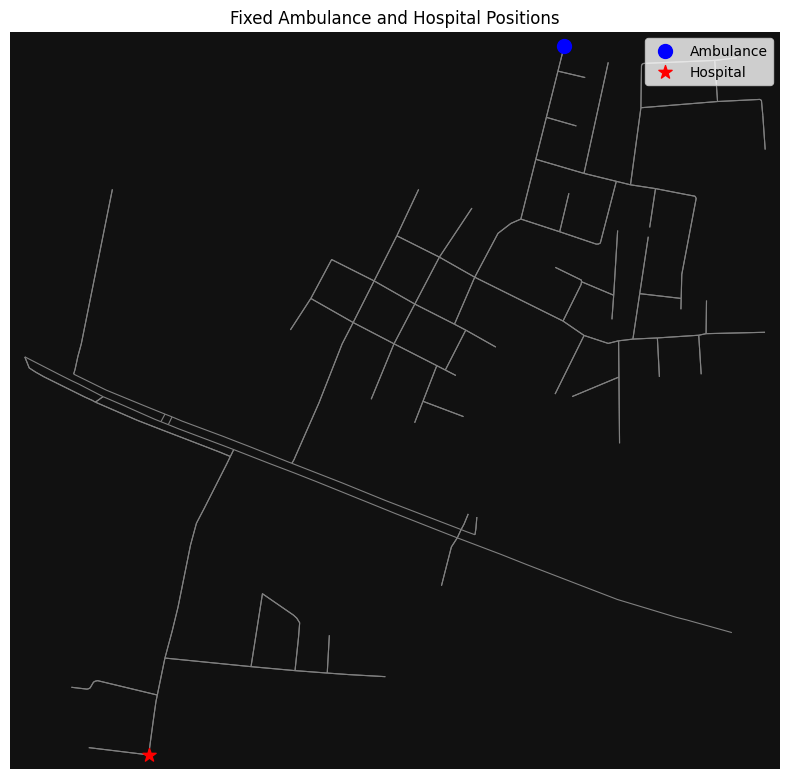

In [5]:
xs = [data['x'] for _, data in G_proj.nodes(data=True)]
ys = [data['y'] for _, data in G_proj.nodes(data=True)]
print("Longitude range:", min(xs), "to", max(xs))
print("Latitude range:", min(ys), "to", max(ys))

import heapq

#Convert node data to lists of lat/lon
node_coords = [(node, data['y'], data['x']) for node, data in G_proj.nodes(data=True)]

# Hospital = bottom-left (min lat + min lon)
hospital_node_id = min(node_coords, key=lambda x: (x[1], x[2]))[0]

# Ambulance = top-right (max lat + max lon)
ambulance_node_id = max(node_coords, key=lambda x: (x[1], x[2]))[0]

#print("Ambulance node ID:", ambulance_node_id)
print("Hospital node ID:", hospital_node_id)

# Plot to confirm
fig, ax = ox.plot_graph(G_proj, node_size=0, edge_color='gray', edge_linewidth=0.8, show=False, close=False)
ax.scatter(G_proj.nodes[ambulance_node_id]['x'], G_proj.nodes[ambulance_node_id]['y'], c='blue', s=100, label='Ambulance')
ax.scatter(G_proj.nodes[hospital_node_id]['x'], G_proj.nodes[hospital_node_id]['y'], c='red', s=100, marker='*', label='Hospital')
plt.legend()
plt.title("Fixed Ambulance and Hospital Positions")
plt.tight_layout()
#plt.show()

In [6]:
# ------------------------------------------------------------
# Randomize ambulance start node (on-map, connected, sensible distance)
# Run this BEFORE the Corridor → QUBO → QAOA cell
# ------------------------------------------------------------
import random
import networkx as nx

def to_simple_undirected(G_multi: nx.MultiDiGraph) -> nx.Graph:
    Gs = nx.Graph()
    for u, v, data in G_multi.edges(data=True):
        w = float(data.get("weight", data.get("length", 1.0)))
        a, b = (u, v) if u <= v else (v, u)
        if Gs.has_edge(a, b):
            if w < Gs[a][b]["weight"]:
                Gs[a][b]["weight"] = w
        else:
            Gs.add_edge(a, b, weight=w)
    return Gs

# 1) Build simple graph for distances
G_simple = to_simple_undirected(G_proj)

# 2) Ensure hospital exists
t = hospital_node_id
assert t in G_simple, "Hospital node not in graph."

# 3) Compute travel-time distances from hospital to all nodes
dist_to_hosp, _ = nx.single_source_dijkstra(G_simple, t, weight="weight")

# 4) Choose a distance band for “reasonable” randomness (tweak as you like)
#    - Use percentiles so it adapts to your area’s scale
dists = list(dist_to_hosp.values())
dists.sort()
if len(dists) < 10:
    # small graph fallback
    lo, hi = (min(dists), max(dists))
else:
    def pct(p): 
        k = max(0, min(len(dists)-1, int(round(p*(len(dists)-1)))))
        return dists[k]
    lo = pct(0.30)   # 30th percentile distance from hospital
    hi = pct(0.70)   # 70th percentile distance

# 5) Candidates: nodes in same component and within [lo, hi]
component = next(c for c in nx.connected_components(G_simple) if t in c)
candidates = [n for n in component if lo <= dist_to_hosp.get(n, float("inf")) <= hi]

# 6) Pick one at random (fix seed for reproducibility if desired)
seed = None  # e.g., 42 for reproducible picks
rng = random.Random(seed)
if not candidates:
    # Fallback: widen band if needed
    widen = [n for n in component if dist_to_hosp.get(n, float("inf")) < float("inf")]
    assert widen, "No connected candidates found."
    ambulance_node_id = rng.choice(widen)
else:
    ambulance_node_id = rng.choice(candidates)

s = ambulance_node_id  # keep using s/t downstream
print(f"🚑 Randomized start node: {s} | distance-to-hospital ≈ {dist_to_hosp[s]:.2f} (weight units)")

🚑 Randomized start node: 3500405740 | distance-to-hospital ≈ 122.00 (weight units)


In [7]:
# ------------------------------------------------------------
# Corridor → Edge-only QUBO (merged objective) → QAOA (AerSampler)
# ------------------------------------------------------------
import heapq
import networkx as nx
from networkx.algorithms.simple_paths import shortest_simple_paths

from qiskit_optimization import QuadraticProgram
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_algorithms.minimum_eigensolvers import QAOA
from qiskit_algorithms.optimizers import COBYLA
from qiskit_aer.primitives import Sampler as AerSampler  # sampling backend (no statevector limit)


qaoa_path = []
qaoa_path_repaired = []
selected_edges = []

# ---------- helpers ----------
def to_simple_undirected(G_multi: nx.MultiDiGraph) -> nx.Graph:
    """Collapse directions/parallel edges; keep min weight per undirected pair."""
    Gs = nx.Graph()
    for u, v, data in G_multi.edges(data=True):
        w = float(data.get("weight", data.get("length", 1.0)))
        a, b = (u, v) if u <= v else (v, u)
        if Gs.has_edge(a, b):
            if w < Gs[a][b]["weight"]:
                Gs[a][b]["weight"] = w
        else:
            Gs.add_edge(a, b, weight=w)
    return Gs

def add_square_penalty(linear, quadratic, terms, c, weight):
    """
    Add weight * (sum_i a_i * z_i - c)^2 to objective.
    terms: list of (var_name, a_i), z_i ∈ {0,1}. Updates dicts in-place.
    """
    for i, (vi, ai) in enumerate(terms):
        linear[vi] = linear.get(vi, 0.0) + weight * (ai*ai - 2*c*ai)
        for vj, aj in terms[i+1:]:
            key = (vi, vj) if vi < vj else (vj, vi)
            quadratic[key] = quadratic.get(key, 0.0) + weight * (2.0 * ai * aj)

def path_from_selected_edges(Gu, selected_edges, s, t):
    """Return s→t path from selected undirected edges or [] if not connected."""
    H = nx.Graph()
    H.add_nodes_from(Gu.nodes())
    H.add_edges_from(selected_edges)
    if s in H and t in H and nx.has_path(H, s, t):
        return nx.shortest_path(H, s, t)
    return []

# ---------- 1) Corridor ----------
G_simple = to_simple_undirected(G_proj)

# classical shortest path for baseline/seed + target edge count
sp = nx.shortest_path(G_simple, ambulance_node_id, hospital_node_id, weight="weight")
L_edges = len(sp) - 1
print("   - Classical SP length (nodes):", len(sp))

# union of top-k shortest simple paths
k = 30
candidates = set()
for path in heapq.nsmallest(
    k,
    shortest_simple_paths(G_simple, ambulance_node_id, hospital_node_id, weight="weight"),
    key=lambda p: nx.path_weight(G_simple, p, weight="weight")
):
    candidates.update(path)

G_corridor_full = G_proj.subgraph(candidates).copy()

# Cap corridor dynamically by qubit budget ~= #edge variables
TARGET_MAX_QUBITS = 28  # keep <32 to be safe
def build_corridor_by_rings(N_cap):
    keep = set(sp)
    frontier = set(sp)
    while len(keep) < N_cap and frontier:
        nxt = set()
        for u in frontier:
            for v in G_simple.neighbors(u):
                if v not in keep:
                    keep.add(v); nxt.add(v)
                if len(keep) >= N_cap: break
            if len(keep) >= N_cap: break
        frontier = nxt
    return G_proj.subgraph(keep).copy()

if True:
    # Start from a node cap and shrink until edge count (qubits) <= budget
    N_cap = min(18, G_corridor_full.number_of_nodes())  # initial cap
    while True:
        G_corridor = build_corridor_by_rings(N_cap)
        Gc = to_simple_undirected(G_corridor)
        est_qubits = Gc.number_of_edges()  # edge-only vars
        if est_qubits <= TARGET_MAX_QUBITS or N_cap <= 8:
            break
        N_cap -= 1
else:
    G_corridor = G_corridor_full
    Gc = to_simple_undirected(G_corridor)
    est_qubits = Gc.number_of_edges()

print(f"[Corridor] nodes={G_corridor.number_of_nodes()} edges={Gc.number_of_edges()} (≈qubits), cap={N_cap}")

s = ambulance_node_id
t = hospital_node_id
if s not in Gc or t not in Gc:
    raise ValueError("Start or end not present in corridor. Increase k or adjust cap.")

# ---------- 2) Edge-only QUBO ----------
qp = QuadraticProgram()

# Edge variables y_{u,v} for undirected edges (u<v)
edge_vars = {}
for u, v, data in Gc.edges(data=True):
    a, b = (u, v) if u < v else (v, u)
    name = f"y_{a}_{b}"
    edge_vars[(a, b)] = name
    qp.binary_var(name)

linear = {}
quadratic = {}

# (A) Travel-time cost: sum w_e * y_e  (linear)
for (u, v), var in edge_vars.items():
    w = float(Gc[u][v].get("weight", 1.0))
    linear[var] = linear.get(var, 0.0) + w

# Penalty weights
A_cont = 14.0   # continuity (degree) constraints
A_end  = 14.0   # endpoints degree
B_size = 0.5   # detour penalty toward classical edge count

# (B) Continuity: internal nodes deg(v) = 2
for v in Gc.nodes():
    if v in (s, t):
        continue
    terms = []
    for nb in Gc.neighbors(v):
        a, b = (v, nb) if v < nb else (nb, v)
        terms.append((edge_vars[(a, b)], 1.0))
    add_square_penalty(linear, quadratic, terms, c=2.0, weight=A_cont)

# (C) Endpoints: deg(s) = 1, deg(t) = 1
for v, c_target in [(s, 1.0), (t, 1.0)]:
    terms = []
    for nb in Gc.neighbors(v):
        a, b = (v, nb) if v < nb else (nb, v)
        terms.append((edge_vars[(a, b)], 1.0))
    add_square_penalty(linear, quadratic, terms, c=c_target, weight=A_end)

# (D) Soft size: (sum_e y_e - L_edges)^2 to discourage detours
terms = [(var, 1.0) for var in edge_vars.values()]
add_square_penalty(linear, quadratic, terms, c=float(L_edges), weight=B_size)

# Single merged objective
qp.minimize(linear=linear, quadratic=quadratic)
qubo = QuadraticProgramToQubo().convert(qp)

# ---------- 3) Solve with QAOA (AerSampler) ----------
print("⚙️  Solving QUBO with QAOA… (qubits≈edges:", Gc.number_of_edges(), ")")
sampler = AerSampler()  # no arguments here
qaoa = QAOA(sampler=sampler, optimizer=COBYLA(maxiter=150), reps=2)
qaoa.sampler.options.shots = 4096
solver = MinimumEigenOptimizer(qaoa)
result = solver.solve(qubo)
print("✅ QAOA objective value:", result.fval)

# ---------- 4) Decode → edges → s–t path ----------
solution = dict(zip([v.name for v in result.variables], result.x))
selected_edges = [(u, v) for (u, v), name in edge_vars.items() if solution.get(name, 0) > 0.5]

qaoa_path = path_from_selected_edges(Gc, selected_edges, s, t)
if qaoa_path:
    print("🚑 QAOA path:", qaoa_path)
    cost = sum(G_simple[qaoa_path[i]][qaoa_path[i+1]]["weight"] for i in range(len(qaoa_path)-1))
    print(f"    → cost ≈ {cost:.2f}, length = {len(qaoa_path)}")
else:
    print("❗ QAOA didn’t return a clean s→t path. Try increasing penalties (A_cont/A_end), COBYLA iters, or widen cap slightly.")

   - Classical SP length (nodes): 15
[Corridor] nodes=18 edges=18 (≈qubits), cap=18
⚙️  Solving QUBO with QAOA… (qubits≈edges: 18 )
✅ QAOA objective value: -837.0
❗ QAOA didn’t return a clean s→t path. Try increasing penalties (A_cont/A_end), COBYLA iters, or widen cap slightly.


In [8]:
# ------------------------------------------------------------
# Repair + Prune for edge-selected QAOA (edge-only model)
# Uses Gc (simple undirected corridor), G_simple (baseline), s, t, and `selected_edges`
# Produces: qaoa_path_repaired (list of nodes) or []
# ------------------------------------------------------------
import networkx as nx

def spur_prune(H, s, t):
    """Remove dangling spurs (deg=1) that aren't s or t, iteratively."""
    changed = True
    while changed:
        changed = False
        leaves = [n for n, d in H.degree() if d == 1 and n not in (s, t)]
        if leaves:
            H.remove_nodes_from(leaves)
            changed = True
    return H

def ensure_connectivity_by_shortcuts(G_metric, H, s, t, max_steps=4):
    """
    If H has no s->t path, connect components by adding the cheapest
    shortest-path 'shortcut' from the s-component toward the t-component.
    """
    steps = 0
    while steps < max_steps and (not H.has_node(s) or not H.has_node(t) or not nx.has_path(H, s, t)):
        steps += 1
        # Identify components; find the one containing s
        comps = list(nx.connected_components(H))
        comp_by_node = {}
        for idx, C in enumerate(comps):
            for n in C:
                comp_by_node[n] = idx
        if s not in comp_by_node:
            # If s got pruned out, re-add it
            H.add_node(s)
            comp_by_node[s] = len(comps)
        if t not in comp_by_node:
            H.add_node(t)
            comp_by_node[t] = len(comps) + 1

        # If already connected, stop
        if nx.has_path(H, s, t):
            break

        # Find the cheapest shortcut from any node in s-comp to any node in NOT s-comp
        Cs = comps[comp_by_node[s]] if s in comp_by_node else {s}
        best_cost, best_path = float("inf"), None
        targets = set(G_metric.nodes()) - set(H.nodes())  # try nodes outside H first
        if not targets:
            targets = set(G_metric.nodes())  # fallback: allow any

        # Search a few seeds from Cs to t (fast heuristic)
        seeds = list(Cs)[: min(8, len(Cs))]
        for a in seeds:
            try:
                p = nx.shortest_path(G_metric, a, t, weight="weight")
                c = nx.path_weight(G_metric, p, weight="weight")
                if c < best_cost:
                    best_cost, best_path = c, p
            except nx.NetworkXNoPath:
                continue

        # If we didn't find a path to t directly, connect to nearest outside node
        if best_path is None:
            for a in seeds:
                # pick a few random targets to limit work
                for b in list(targets)[:50]:
                    try:
                        p = nx.shortest_path(G_metric, a, b, weight="weight")
                        c = nx.path_weight(G_metric, p, weight="weight")
                        if c < best_cost:
                            best_cost, best_path = c, p
                    except nx.NetworkXNoPath:
                        continue

        if best_path is None:
            break  # give up

        # Add best_path edges into H
        H.add_nodes_from(best_path)
        H.add_edges_from([(best_path[i], best_path[i+1]) for i in range(len(best_path)-1)])

    return H

# Build subgraph H from selected edges
H = nx.Graph()
H.add_nodes_from(Gc.nodes())
H.add_edges_from(selected_edges)

# First prune spurs, then ensure connectivity, then prune again
H = spur_prune(H, s, t)
if not (H.has_node(s) and H.has_node(t) and nx.has_path(H, s, t)):
    H = ensure_connectivity_by_shortcuts(G_simple, H, s, t, max_steps=4)
    H = spur_prune(H, s, t)

# Extract final simple s->t path (or empty if not possible)
if H.has_node(s) and H.has_node(t) and nx.has_path(H, s, t):
    qaoa_path_repaired = nx.shortest_path(H, s, t, weight="weight")
    cost_repaired = nx.path_weight(G_simple, qaoa_path_repaired, weight="weight")
    print("🩺 QAOA repaired path:", qaoa_path_repaired)
    print(f"    → cost ≈ {cost_repaired:.2f}, length = {len(qaoa_path_repaired)}")
else:
    qaoa_path_repaired = []
    print("❗ Could not repair into a clean s→t path. Consider increasing penalties or corridor width.")

🩺 QAOA repaired path: [3500405740, 3500405738, 3500405734, 10172938611, 10172938610, 10172938609, 6196989893, 3500405745, 2099691661, 8530739259, 1906888933, 7736381401, 1314077247, 7478154497, 1314077248]
    → cost ≈ 122.00, length = 15


Classical: len=15  cost≈122.00
QAOA     : len=15  cost≈122.00
Δ cost   : +0.00  (+0.0%)


/var/folders/rd/_m18brv13n1df537jkrvc1pw0000gn/T/ipykernel_85790/1919040639.py:80: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.axis('off'); plt.tight_layout(); plt.show()


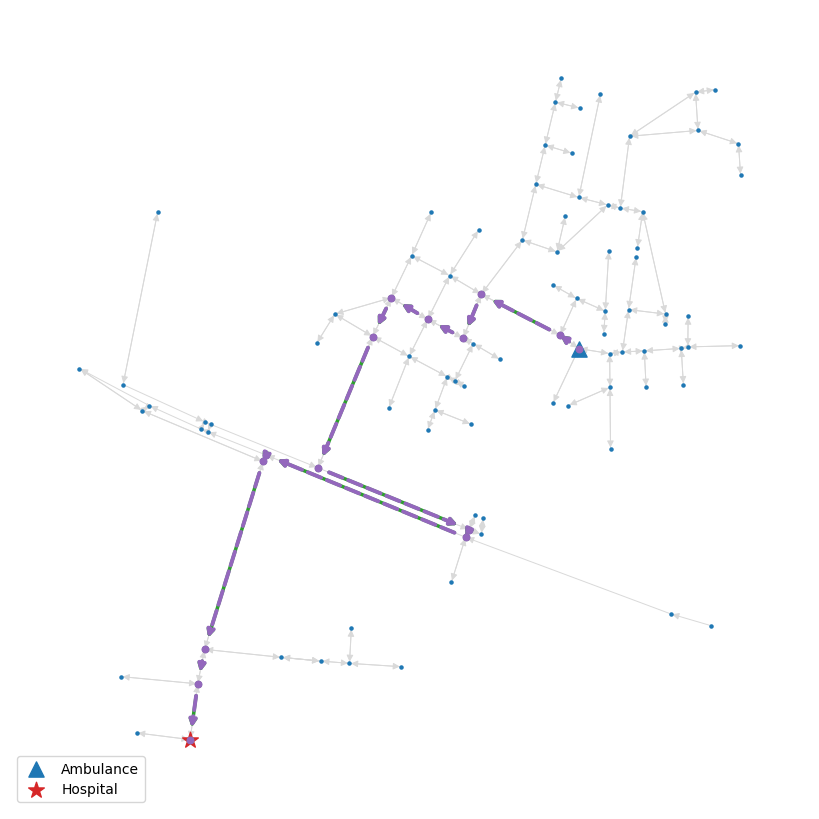

In [11]:
# ------------------------------------------------------------
# Rescue final path → Compare vs Classical → Plot
# ------------------------------------------------------------
import networkx as nx
import matplotlib.pyplot as plt

# 0) Ensure s,t and G_simple exist
s = globals().get('s', ambulance_node_id)
t = globals().get('t', hospital_node_id)

def to_simple_undirected(G_multi: nx.MultiDiGraph) -> nx.Graph:
    Gs = nx.Graph()
    for u, v, data in G_multi.edges(data=True):
        w = float(data.get("weight", data.get("length", 1.0)))
        a, b = (u, v) if u <= v else (v, u)
        if Gs.has_edge(a, b):
            if w < Gs[a][b]["weight"]:
                Gs[a][b]["weight"] = w
        else:
            Gs.add_edge(a, b, weight=w)
    return Gs

if 'G_simple' not in globals():
    G_simple = to_simple_undirected(G_proj)

# 1) Try to get a usable path
qaoa_path_final = None

if 'qaoa_path' in globals() and qaoa_path:
    qaoa_path_final = qaoa_path
elif 'qaoa_path_repaired' in globals() and qaoa_path_repaired:
    qaoa_path_final = qaoa_path_repaired
elif 'selected_edges' in globals() and selected_edges:
    # attempt to reconstruct a path from selected edges
    Gc = to_simple_undirected(G_proj.subgraph(G_proj.nodes()).copy()) if 'Gc' not in globals() else Gc
    H = nx.Graph()
    H.add_nodes_from(Gc.nodes())
    H.add_edges_from(selected_edges)
    if s in H and t in H and nx.has_path(H, s, t):
        qaoa_path_final = nx.shortest_path(H, s, t)

# If still missing, stop with a helpful hint
if not qaoa_path_final:
    raise RuntimeError("No QAOA path found in scope. Re-run the QAOA cell, or run your Repair+Prune cell to create qaoa_path_repaired.")

# 2) Classical baseline and costs
sp_classical = nx.shortest_path(G_simple, s, t, weight="weight")
cost_classical = sum(G_simple[sp_classical[i]][sp_classical[i+1]]["weight"]
                     for i in range(len(sp_classical)-1))
cost_qaoa = sum(G_simple[qaoa_path_final[i]][qaoa_path_final[i+1]]["weight"]
                for i in range(len(qaoa_path_final)-1))

delta = cost_qaoa - cost_classical
pct = (delta / cost_classical * 100.0) if cost_classical else float('nan')

print(f"Classical: len={len(sp_classical)}  cost≈{cost_classical:.2f}")
print(f"QAOA     : len={len(qaoa_path_final)}  cost≈{cost_qaoa:.2f}")
print(f"Δ cost   : {delta:+.2f}  ({pct:+.1f}%)")

# 3) Plot overlay
pos = {n: (G_proj.nodes[n]['x'], G_proj.nodes[n]['y']) for n in G_proj.nodes}

plt.figure(figsize=(8,8))
nx.draw(G_proj, pos=pos, node_size=5, width=0.7, edge_color='0.85')

nx.draw_networkx_edges(G_proj, pos,
    edgelist=list(zip(sp_classical[:-1], sp_classical[1:])),
    width=2.5, edge_color='tab:green', label='Classical SP')
nx.draw_networkx_nodes(G_proj, pos, nodelist=sp_classical, node_size=18, node_color='tab:green')

nx.draw_networkx_edges(G_proj, pos,
    edgelist=list(zip(qaoa_path_final[:-1], qaoa_path_final[1:])),
    width=2.8, edge_color='tab:purple', style='--', label='QAOA path')
nx.draw_networkx_nodes(G_proj, pos, nodelist=qaoa_path_final, node_size=22, node_color='tab:purple')

plt.scatter([G_proj.nodes[s]['x']], [G_proj.nodes[s]['y']], s=120, marker='^', color='tab:blue', label='Ambulance')
plt.scatter([G_proj.nodes[t]['x']], [G_proj.nodes[t]['y']], s=140, marker='*', color='tab:red', label='Hospital')

plt.legend(loc='lower left')
plt.axis('off'); plt.tight_layout(); plt.show()

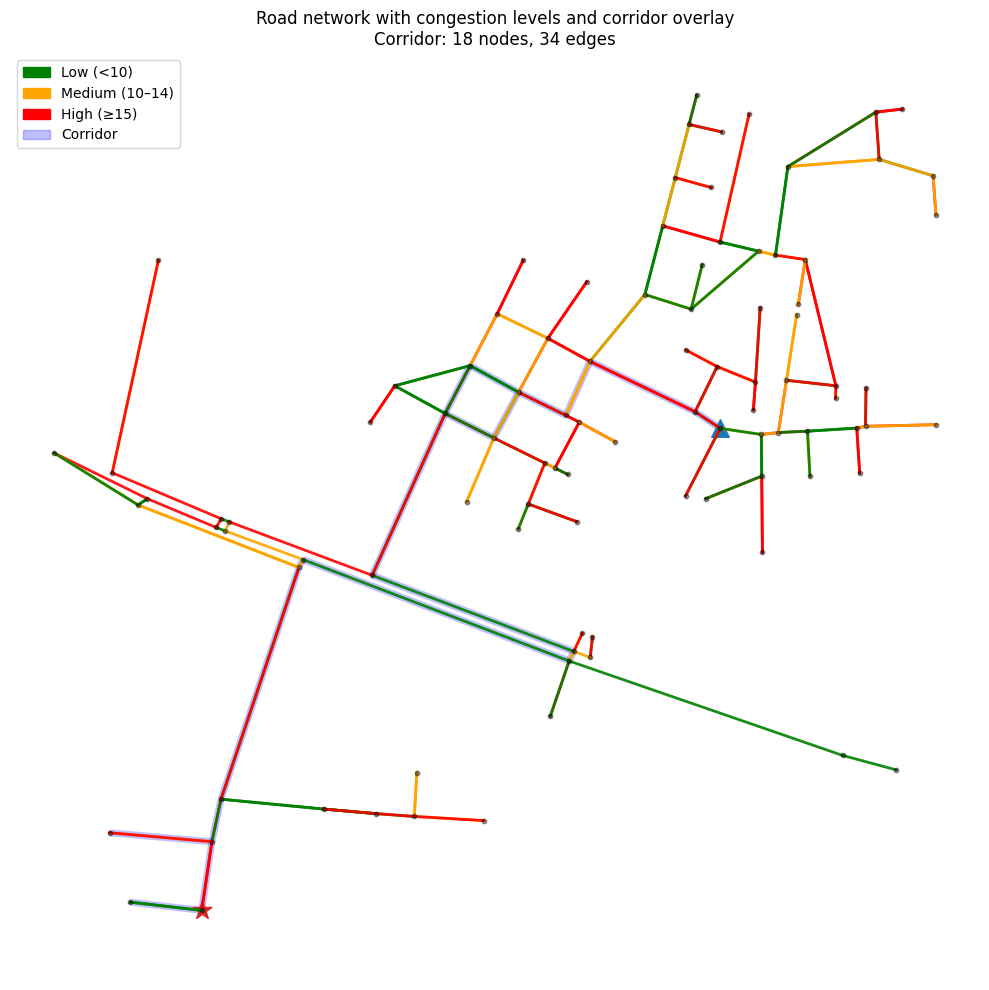

In [23]:
# ================================
# Visualize full graph with congestion colors + corridor highlight
# ================================
import matplotlib.pyplot as plt
import networkx as nx

# --- sanity checks ---
assert 'G_proj' in globals(), "G_proj missing."
assert 'G_corridor' in globals(), "G_corridor missing."
assert 's' in globals() and 't' in globals(), "Start 's' and end 't' nodes must be defined."

WEIGHT_ATTR = "weight"

# positions for plotting
pos = {n: (G_proj.nodes[n]['x'], G_proj.nodes[n]['y']) for n in G_proj.nodes}

# --- helper to pick color based on weight ---
def weight_to_color(w):
    if w < 10:     # low congestion
        return "green"
    elif w < 15:   # medium congestion
        return "orange"
    else:          # high congestion
        return "red"

# full plot
fig, ax = plt.subplots(figsize=(10, 10))

# draw all edges with congestion colors
for u, v, d in G_proj.edges(data=True):
    w = float(d.get(WEIGHT_ATTR, 1.0))
    color = weight_to_color(w)
    ax.plot([pos[u][0], pos[v][0]], [pos[u][1], pos[v][1]],
            color=color, linewidth=2.0, alpha=0.9)

# ---- soft corridor highlight overlay ----
Gc_simple = nx.Graph()
for u, v, _ in G_corridor.edges(data=True):
    a, b = (u, v) if u < v else (v, u)
    if not Gc_simple.has_edge(a, b):
        Gc_simple.add_edge(a, b)

corr_edges = list(Gc_simple.edges())
# faint highlight overlay (cyan + transparency so congestion colors still show)
nx.draw_networkx_edges(Gc_simple, pos, edgelist=corr_edges,
                       width=5.0, edge_color='blue', alpha=0.25, ax=ax, label="Corridor")

# nodes: optional small dots
nx.draw_networkx_nodes(G_proj, pos, node_size=10, node_color='black', alpha=0.4, ax=ax)

# endpoints
ax.scatter([pos[s][0]], [pos[s][1]], s=160, marker='^', color='tab:blue', label='Ambulance Start')
ax.scatter([pos[t][0]], [pos[t][1]], s=200, marker='*', color='tab:red', label='Hospital')

# legend for congestion levels
import matplotlib.patches as mpatches
legend_elems = [
    mpatches.Patch(color="green", label="Low (<10)"),
    mpatches.Patch(color="orange", label="Medium (10–14)"),
    mpatches.Patch(color="red", label="High (≥15)"),
    mpatches.Patch(color="blue", alpha=0.25, label="Corridor"),
]
ax.legend(handles=legend_elems, loc="upper left")

ax.set_title(f"Road network with congestion levels and corridor overlay\n"
             f"Corridor: {G_corridor.number_of_nodes()} nodes, {G_corridor.number_of_edges()} edges")
ax.axis("off")
plt.tight_layout()
plt.show()